# Числовые функции и численное дифференцирование: программная реализация, ОО подход

In [1]:
# стандартные imports
import math as m
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.rc('font', size=20)

## Отличия вычислительного ООП от классического ООП

В прошлой лекции для записи/чтения полей класса мы использовали сеттеры и геттеры. В вычислительном ООП последние используются __только если чтение/запись поля требует выполения дополнительного кода__. А если сеттеры/геттеры отсутствуют --- поля должны быть помечены как public.

__Итак__: далее в курсе поля и методы (за редкими исключениями) будут public.

## Представление функции с параметрами в виде класса
Пример с вертикальным движением тела в поле силы тяжести: $y(t) = v_0 t - \frac{g t^2}{2}$. В качестве параметров возьмем $v_0$ и $g$. Каким образом лучше реализовать данную функцию? 

__Очевидное решение__: функция нескольких аргументов.

In [2]:
def YVertical(t, v0, g):
    return v0*t - 0.5*g*(t**2)

Однако при проведении численного дифференцирования данной функции возникнет проблема, так как функции взятия производной в качестве аргумента требуется функция 1 переменной.

К сожалению, функция Derivative() не сможет работать с нашей YVertical.


__Неудачное решение__: использование глобальных переменных.

In [3]:
g = 9.8 
x0 = 5. # случайное значение
v0 = 5.2 # случайное значение

def YVertical1(t):
    return v0*t - 0.5*g*(t**2)

Как известно, использование глобальных переменных требуется сводить к минимуму с целью избегания ошибок из-за конфликтов в именах в различных областях видимости.

__Другой способ__: Для каждого значения параметра v0 можно написать отдельную функцию (еще неудачней). Написание же n-го количества версий первой для функций с количеством аргументов от 1 до n  представляется не очень оптимальным решением данной задачи. Мы же стремимся к написанию ПО, работающему в самых общих случаях.

Как решить проблему? Использовать __классы__. Переменные класса видны всем его методам, поэтому в контексте класса их можно рассматривать в качестве "глобальных":

In [4]:
class YVertical:
    def __init__(self, v0):
        self.g = 9.81
        self.v0 = v0
        
    def Evaluate(self, t):
        return self.v0*t - 0.5*self.g*(t**2)

In [5]:
# использование
ball = YVertical(v0)
print(ball(x0))

-96.625


Итак, для представления функции n переменных $ f \left( x; p_1, ..., p_n \right) $, часть которых можно считать параметрами в контексте использования функции в программе, создаем класс:

 


In [6]:
# набросок: класс для функции с n-параметрами;
# нерабочий код
class MyFunction:
    
    def __init__(self, p1, p2, pn):
        self.p1 = p1
        self.p2 = p2
        self.pn = pn
    
    def Evaluate(self, x):
        return <smth>

SyntaxError: invalid syntax (<ipython-input-6-01f3c5c4beb0>, line 11)

Для большего удобства использования класса в качестве функции, вместо конструкции __object.Evaluate(x)__ хотелось бы использовать более привычную операцию вызова функции __object(x)__. Т.е. нужно перегрузить оператор "()". В языке Python перегрузку операторов производят т.н. __магические методы__. Конкретно оператор "()" перегружает магический метод --call--:

In [7]:
# набросок для функции с n-параметрами;
# нерабочий код
class MyFunction:
    
    def __init__(self, p1, p2, pn):
        self.p1 = p1
        self.p2 = p2
        self.pn = pn
    

    def __call__(self, x): # "заменяет" функцию Evaluate(x) 
        return <smth>      # object(x) - это то же самое, что вызов object.__self(x)__

SyntaxError: invalid syntax (<ipython-input-7-2d73dc76e24e>, line 12)

Итак, еще раз:

In [8]:
# рабочий код
class YVertical:
    def __init__(self, v0):
        self.g = 9.81
        self.v0 = v0
        
    def __call__(self, t):
        return self.v0*t - 0.5*self.g*(t**2)

In [9]:
# использование
Y1 = YVertical(v0)
print(Y1(x0))

-96.625


Объекты, в которых реализован метод __--call--__(), называются __функторами__.

## Магические методы
Их имеется довольно большое количество:

* __--init--__(self)
Конструктор

* __--del--__(self) 
Деструктор

* __--pos--__(self)
Определяет поведение для унарного плюса (+some_object)


* __--neg--__(self)
Определяет поведение для отрицания (-some_object)


* __--abs--__(self)
Определяет поведение для функции abs()

* __--str--__(self)
Определяет поведение для функции print()


* __--invert--__(self)
Определяет поведение для инвертирования оператором ~


* __--round--__(self, n)
Определяет поведение для встроенной функции round(). n это число знаков после запятой, до которого округлить


* __--floor--__(self)
Определяет поведение для math.floor(), то есть, округления до ближайшего меньшего целого


* __--ceil--__(self)
Определяет поведение для math.ceil(), то есть, округления до ближайшего большего целого.

.........................

## Автоматическое дифференцирование функций
Рассмотрим различные способы реализации операции дифференцирования. 

__1-й способ__:

In [10]:
def DerivativeNum(f, x, h):
    return (f(x + h) - f(x - h))/ (2.*h)

In [11]:
# использование
h0 = 1e-4
TestFunction = lambda x: (x**2)*np.sin(2*m.pi*x)
print (DerivativeNum(TestFunction, x0, h0))

157.079622406


__2-й способ__: функция, возвращающая функцию (т.н. __замыкание__). __Замыкание__ (англ. "closure") — функция, в теле которой присутствуют ссылки на переменные, объявленные вне тела этой функции в окружающем коде и не являющиеся её параметрами.

In [12]:
def DerivativeNum(f, h):
    
    def dfdx(x):
        return (f(x + h) - f(x - h))/(2.*h)
        
    return dfdx # это замыкание помнит значение внешних переменных f и h

In [13]:
Derivative1 = DerivativeNum(TestFunction, h0) # теперь Derivative_1 ведет себя как обыкновенная функция
print(Derivative1(x0))

157.079622406


__3-й способ__: написание отдельного класса, способного вызывать функцию и хранить её состояние в полях.

In [14]:
# класс для представления производной, 
# вычисляющейся с помощью формулы численного дифференцирования
class DerivativeNum:
    
    def __init__(self, f, h):
        self.f = f
        self.h = h

    def __call__(self, x):
        f, h = self.f, self.h # для краткости
        return (f(x + h) - f(x - h))/(2.*h)

In [15]:
# использование
derivative1 = DerivativeNum(TestFunction, h0)

print(derivative1(x0)) # теперь derivative1 можно вызывать как функцию

157.079622406


__В дальнейшем будем использовать последний способ__. Перейдем к использованию класса: протестируем его на различных функциях.

__ НА ЗАМЕТКУ__: напоминаю, что всё в Python является объектом, в том числе и функции. Т.е. ее тоже можно рассматривать как функциональный объект, что позволяет взаимодействовать с ней как с обыкновенной переменной (помещать в списки, к примеру). В языке С для реализации массива из функций пришлось бы использовать указатели на функции, что порождает множество сложностей (громоздкость), если эти функции имеют различное число аргументов и различные возвращаемые значения [ пример объявления указателя: __int (*ptrToFunction)(float, char, char);__ ].

Для оценки погрешности численного дифференцирования потребуются аналитические значения производных, которые получим с помощью библиотеки SymPy:

### Библиотека символьных вычислений SymPy

Позволяет решать часто встречающиеся задачи:

* упрощение символьных выражений
* символьное дифференцирование
* символьное интегрирование
* разложение в ряды
* символьное решение ОДУ
* прочее.

__Минусы__: уступает по функционалу коммерческому пакету Wolfram Mathematica

__Плюсы__: позволяет решать задачи символьных вычислений внутри той же рабочей среды (программы на Python или Jupyter Notebook), что и "стандартные" вычисления.

In [16]:
import sympy as smp
xSym = smp.Symbol('x')

# код для отображения формул в формате LaTex
smp.init_printing(use_latex='mathjax')
import IPython.display as ipy

Демонстрация работы некоторых функций из SymPy:

In [20]:
U = xSym**2 * smp.sin(2 * smp.pi * xSym) # определяем символьную функцию U

dUdx = smp.diff(U, xSym) # вторым аргументом указывается переменная дифференцирования
d2Udx = smp.diff(dUdx, xSym)
d2Udx = smp.simplify(d2Udx)

Series1 = U.series(xSym, 0, 10).removeO() # до O(x^10)

#print(U)
ipy.display(U) # вместо print(), более продвинутый вывод
ipy.display(Series1) # вместо print()
ipy.display(dUdx) # вместо print()
ipy.display(d2Udx) # вместо print()

 2           
x ⋅sin(2⋅π⋅x)

     7  9      5  7      3  5         
  8⋅π ⋅x    4⋅π ⋅x    4⋅π ⋅x         3
- ─────── + ─────── - ─────── + 2⋅π⋅x 
    315        15        3            

     2                            
2⋅π⋅x ⋅cos(2⋅π⋅x) + 2⋅x⋅sin(2⋅π⋅x)

     2  2                                             
- 4⋅π ⋅x ⋅sin(2⋅π⋅x) + 8⋅π⋅x⋅cos(2⋅π⋅x) + 2⋅sin(2⋅π⋅x)

В данной лекции нам потребуется только перевод символьных функций в "обычные" функции Python. Этим занимается функция lambdify из библиотеки SymPy:

In [23]:
# символьные функции требуют явного указания аргумента 
# (в отличие от "численных" из библиотеки math)
FuncSym1 = smp.sin(xSym) 
Func1 = smp.lambdify(xSym, FuncSym1) # "обычная" функция

# проверка работы
print(Func1(x0))

-0.958924274663


Давайте построим графики численных производных для следующих функций:
* sin(x)
* cos(x)
* exp(x)
* tan(x).

Покомпонентное примение lambdify к списку символьных функций:

In [24]:
# символьные функции требуют явного указания аргумента (в отличие от "численных" из библиотеки math)
functionsSym = [smp.sin(xSym), smp.cos(xSym), smp.exp(xSym), smp.tan(xSym)] 

# генерируем "обычные" функции из символьных: этим занимается функция lambdify
functions = [smp.lambdify(xSym, f) for f in functionsSym]

Используем написанный класс:

In [26]:
derivativesNum = []

for f in functions:
    derivativesNum.append(DerivativeNum(f, h0))

ipy.display(functionsSym, functions, derivativesNum)
#print(symbolicFunctions, '\n\n', functions)

⎡                 x        ⎤
⎣sin(x), cos(x), ℯ , tan(x)⎦

[<function numpy.<lambda>>,
 <function numpy.<lambda>>,
 <function numpy.<lambda>>,
 <function numpy.<lambda>>]

Построение графиков численных производных:

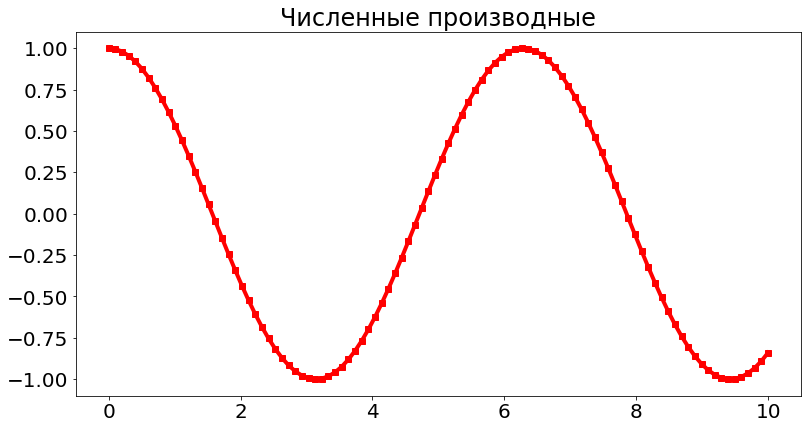

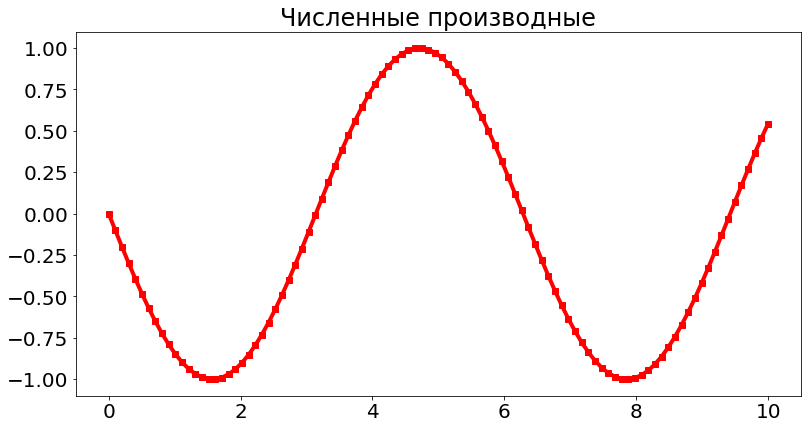

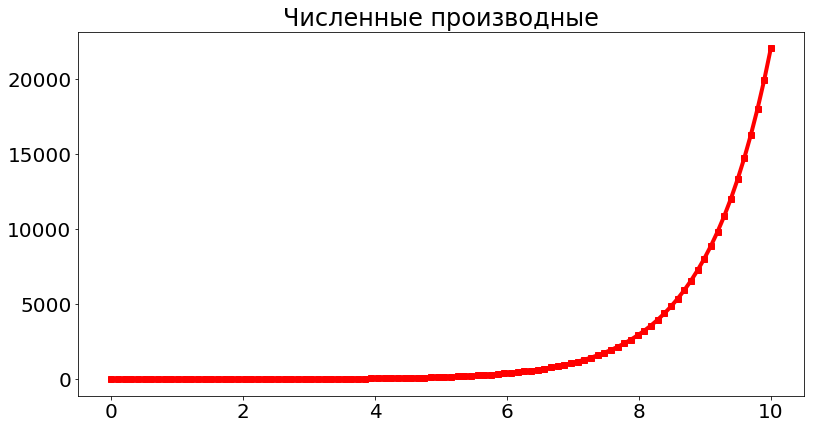

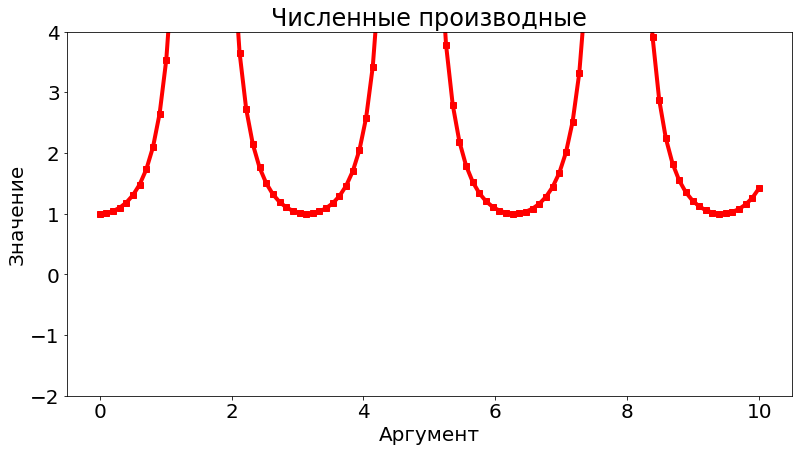

In [32]:
xLeft, xRight = 0., 10.
numPoints = 100
xData = np.linspace(xLeft, xRight, numPoints)


figureSizeConst = (13, 6.7) # в дюймах
#plt.figure(figsize=figureSizeConst) # строим графики производных в общем окне
#plt.title('Численные производные')

for derivativeNum in derivativesNum:   
    yData = derivativeNum(xData) # векторизованная операция над массивом xData
    
    plt.figure(figsize=figureSizeConst)
    plt.title('Численные производные')
    # на каждой итерации, построение графика в ОДНОМ окне, созданном plt.figure() выше
    plt.plot(xData, yData, 'r-s', linewidth = 4)

plt.xlabel('Аргумент')
plt.ylabel('Значение')
plt.ylim([-2., 4.])
plt.show()

### Анализ сходимости формул численного дифф.

In [34]:
derivativesAnalyticalSym = [smp.diff(f, xSym) for f in functionsSym]
ipy.display(derivativesAnalyticalSym)

# символьное дифференцирование; используем генераторы списков
derivativesAnalytical = [smp.lambdify(xSym, f) \
                        for f in derivativesAnalyticalSym]
ipy.display(derivativesAnalytical)

⎡                  x     2       ⎤
⎣cos(x), -sin(x), ℯ , tan (x) + 1⎦

[<function numpy.<lambda>>,
 <function numpy.<lambda>>,
 <function numpy.<lambda>>,
 <function numpy.<lambda>>]

Построение зависимости погрешностей формул численного дифференцирования от величины шага:

In [35]:
steps = [2**(-n) for n in range(2, 15)]
print('Шаги: ', steps)

Шаги:  [0.25, 0.125, 0.0625, 0.03125, 0.015625, 0.0078125, 0.00390625, 0.001953125, 0.0009765625, 0.00048828125, 0.000244140625, 0.0001220703125, 6.103515625e-05]


[0.002945594365654558, 0.00073812671043615996, 0.00018463983583638655, 4.6166721206497563e-05, 1.1542102976158652e-05, 2.8855521684301166e-06, 7.2138969431367883e-07, 1.8034752502504858e-07, 4.5086876121480657e-08, 1.1271749422725463e-08, 2.8179961697460953e-09, 7.0455785650125335e-10, 1.7659618212206851e-10] 

[0.0099576259554103874, 0.0024952484211413495, 0.0006241777357968159, 0.00015606729382822149, 3.9018252323663738e-05, 9.7546523875058355e-06, 2.4386686717781103e-06, 6.0966751502800065e-07, 1.5241690787259898e-07, 3.8104224109325457e-08, 9.5260815902165064e-09, 2.3815459604392686e-09, 5.9552573983268076e-10] 

[1.5508087603080583, 0.38679466153078579, 0.096642023921759801, 0.024156967123445838, 0.0060390206213298825, 0.0015097413338764909, 0.00037743446912941181, 9.435856512141072e-05, 2.3589632775156133e-05, 5.8974287924229429e-06, 1.4743159510999249e-06, 3.6854501672678452e-07, 9.229145803146821e-08] 

[37.368293941293302, 2.8156339052414054, 0.59925891155274336, 0.14444620360

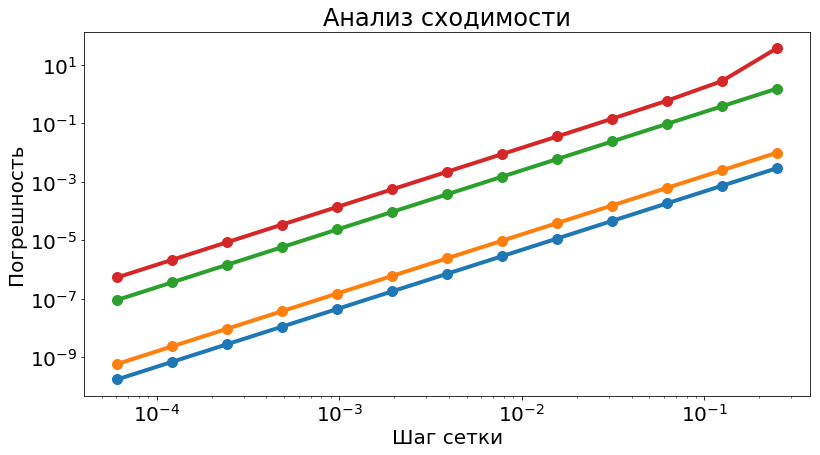

In [43]:
plt.figure(figsize=figureSizeConst)
plt.title('Анализ сходимости')


for f, dfdx in zip(functions, derivativesAnalytical):
        
        errors = []
        
        for h in steps:
            dfdxNum = DerivativeNum(f, h)
            
            error = np.fabs(dfdxNum(x0) - dfdx(x0))
            
            errors.append(error)
        
        print(errors, '\n')
        # на каждой итерации, построение графика в ОДНОМ окне, созданном plt.figure() выше
        plt.loglog(steps, errors, '-o', linewidth=4, markersize=10)
        

plt.xlabel('Шаг сетки')
plt.ylabel('Погрешность')
plt.show()

Все графики имеют наклон $\approx 2$, как и должно быть для формулы численного дифференцирования 2-го порядка точности.

## Вопросы?